### Explainable Neural Networks

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import statsmodels.api as sm
import sklearn

#### Simple Data Generation Process

In [70]:
def generateProcess(
    number : int = 5000,
    random_sate : int = 42,
    number_of_X : int = 2,
) -> np.array :
    np.random.seed(random_sate) # Set NumPy's random seed for reproducibility
    X = np.zeros(shape = (number, number_of_X))
    for i in range(number_of_X) :
        X[:int(number/2), i] = np.random.randn(int(number/2))
        # Use antithetic sampling to reduce the bias in the mean
        X[int(number/2):, i] = -X[:int(number/2), i]
    
    eps = np.zeros(shape=(number,1))
    eps[:int(number/2)] = np.random.randn(int(number/2), 1)
    eps[int(number/2):] = -eps[:int(number/2)]
    
    Y = 0
    
    for i in range(number_of_X) : 
        Y += X[:, i]
        
    Y += eps.flatten()
    
    return Y, X;

In [71]:
Y, X = generateProcess(number_of_X = 2)

In [72]:
Y

array([ 0.64356747,  0.37650625, -1.47926302, ..., -4.95770626,
        1.17540685,  0.68763402])

#### OLS

use OLS to fit a linear model to the data

In [73]:
ols_result = sm.OLS(
    Y, 
    sm.add_constant(X)
).fit()

In [74]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     4479.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:36:52   Log-Likelihood:                -7205.3
No. Observations:                5000   AIC:                         1.442e+04
Df Residuals:                    4997   BIC:                         1.444e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.435e-17      0.014  -9.92e-16      1.0

In [75]:
y_ols = ols_result.predict(sm.add_constant(X))

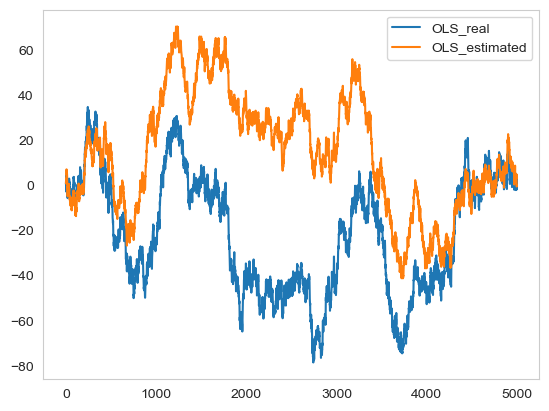

In [76]:
import matplotlib.pyplot as plt
plt.plot(Y.cumsum(), label = 'OLS_real')
plt.plot(y_ols.cumsum(), label = 'OLS_estimated')
plt.legend()
plt.grid(False)

#### Neural Network

In [78]:
def linear_NN0_model(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(1, input_dim = num_X_input, kernel_initializer = 'normal')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model;

In [79]:
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 0, patience = 10)

In [80]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN0_model, 
    epochs = 40,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_15562/4154843586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  linear_neural_network = KerasRegressor(


In [81]:
linear_neural_network.fit(X, Y)

In [82]:
print("weights: " + str(linear_neural_network.model.layers[0].get_weights()[0]))
print("bias: " + str(linear_neural_network.model.layers[0].get_weights()[1]))

weights: [[0.9893442]
 [0.9585765]]
bias: [0.00113693]


In [83]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

#### Multi Layer Perceptron

In [84]:
def linear_NN1_model(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(10, input_dim = num_X_input, kernel_initializer = 'normal')
    )
    model.add(
        Dense(1, kernel_initializer = 'normal', activation = 'linear')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model;

In [85]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN1_model, 
    epochs = 50,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_15562/1859029875.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  linear_neural_network = KerasRegressor(


In [86]:
linear_neural_network.fit(X, Y)

In [87]:
W1 = linear_neural_network.model.get_weights()[0]
b1 = linear_neural_network.model.get_weights()[1]
W2 = linear_neural_network.model.get_weights()[2]
b2 = linear_neural_network.model.get_weights()[3]
print(W1, W2)

[[-0.22381437  0.2937237   0.25400138 -0.3218427   0.3153786   0.33155686
   0.3743086   0.29085907  0.3600886  -0.3369728 ]
 [-0.29346284  0.3017529   0.28752938 -0.34315485  0.3601747   0.27026507
   0.30321383  0.21623786  0.15348275 -0.32774606]] [[-0.4385401 ]
 [ 0.35734177]
 [ 0.39351556]
 [-0.31941134]
 [ 0.31224388]
 [ 0.31645763]
 [ 0.32245484]
 [ 0.3655264 ]
 [ 0.22246222]
 [-0.31997493]]


In [88]:
beta_0 = np.dot(np.transpose(W2), b1) + b2
beta_1 = np.dot(np.transpose(W2), W1[0])
beta_2 = np.dot(np.transpose(W2), W1[1])

In [89]:
print(beta_0, beta_1, beta_2)

[-0.03120065] [1.0242071] [0.9730968]


In [90]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

#### feedforward Neural Network

using $\tanh$ activation function

In [91]:
def linear_NN1_model_act(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(10, input_dim = num_X_input, kernel_initializer = 'normal', activation = 'tanh')
    )
    model.add(
        Dense(1, kernel_initializer = 'normal')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model;

In [92]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN1_model_act, 
    epochs = 50,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_15562/3029664705.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  linear_neural_network = KerasRegressor(


In [93]:
linear_neural_network.fit(X, Y)

In [94]:
W1 = linear_neural_network.model.get_weights()[0]
b1 = linear_neural_network.model.get_weights()[1]
W2 = linear_neural_network.model.get_weights()[2]
b2 = linear_neural_network.model.get_weights()[3]
print(W1, W2)

[[ 0.15984647  0.14963858  0.16746126 -0.14234158 -0.2277824  -0.17488919
  -0.141768   -0.16895789  0.1562501  -0.19259238]
 [ 0.17036904  0.18898699  0.15737641 -0.2011269  -0.07054006 -0.14617404
  -0.20372848 -0.15498866  0.17631906 -0.1200993 ]] [[ 0.6069987 ]
 [ 0.70819676]
 [ 0.55581886]
 [-0.5753532 ]
 [-0.591009  ]
 [-0.64659715]
 [-0.60462743]
 [-0.561211  ]
 [ 0.5661717 ]
 [-0.73286885]]


In [95]:
beta_0 = np.dot(np.transpose(W2), b1) + b2
beta_1 = np.dot(np.transpose(W2), W1[0])
beta_2 = np.dot(np.transpose(W2), W1[1])

In [96]:
print(beta_0, beta_1, beta_2)

[0.04025559] [1.0358264] [0.97465616]


In [97]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

#### Sensitivities

In [109]:
def sensitivities(model, X) :
    W1 = model.model.get_weights()[0]
    b1 = model.model.get_weights()[1]
    W2 = model.model.get_weights()[2]
    b2 = model.model.get_weights()[3]
    
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    
    beta = np.array(
        [0] * M * (p+1),
        dtype = 'float64'
    ).reshape(M, p + 1)
    
    beta[:, 0] = (np.dot(np.transpose(W2), np.tanh(b1)) + b2)[0]
    for i in range(M) :
        Z1 = np.tanh(
            np.dot(
                np.transpose(W1), np.transpose(X[i,])
            ) + b1
        )
        D = np.diag(1 - Z1 ** 2);
        
        for j in range(p) :
            beta[i, j+1] = np.dot(np.transpose(W2), np.dot(D, W1[j]))
    
    return beta

In [110]:
beta = sensitivities(linear_neural_network, X)

Check that the intercept is close to one and the coefficients are close to one

In [111]:
print(np.mean(beta, axis = 0))

[0.04025503 0.98492193 0.9261213 ]


In [112]:
print(np.std(beta, axis = 0))

[0.         0.06260128 0.06093119]


In [113]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])